# Streaming
To set the stage for human-in-the-loop, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

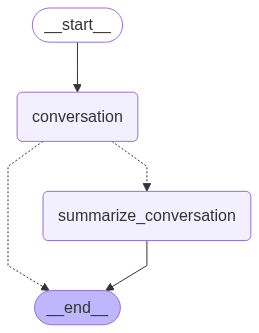

In [1]:
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

from langchain.chat_models import init_chat_model
from typing import Literal

model = init_chat_model(
    "anthropic.claude-3-haiku-20240307-v1:0",
    model_provider="bedrock_converse",
)

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


### Streaming full state
.stream and .astream are sync and async methods for streaming back results.

LangGraph supports a few different streaming modes for graph state:

values: This streams the full state of the graph after each node is called.
updates: This streams updates to the state of the graph after each node is called.

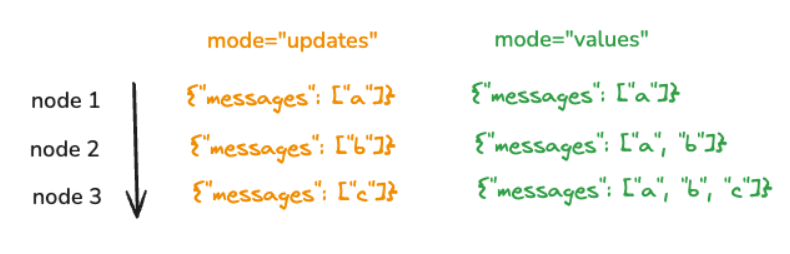

In [2]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hi Lance! It's nice to meet you. I'm Claude, an AI assistant created by Anthropic. I'm here to help with any questions or tasks you might have. Feel free to ask me about anything, and I'll do my best to assist you.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'f2815228-cfbe-475b-b07a-53f6fda55f08', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 15 Jul 2025 22:41:51 GMT', 'content-type': 'application/json', 'content-length': '396', 'connection': 'keep-alive', 'x-amzn-requestid': 'f2815228-cfbe-475b-b07a-53f6fda55f08'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1390]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--8bb1db3a-59a4-41c2-a2c0-3c71f0d4a09a-0', usage_metadata={'input_tokens': 12, 'output_tokens': 58, 'total_tokens': 70, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})}}


In [3]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

It's nice to meet you Lance! I'm Claude, an AI assistant created by Anthropic. I'm here to help with any questions or tasks you might have. Please let me know if there's anything I can assist you with.


This is the full state of the graph after the conversation node is called.

In [4]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

It's nice to meet you, Lance! I'm Claude, an AI assistant created by Anthropic. I'm here to help with any questions or tasks you might have. Please let me know if there's anything I can assist you with.
---------------------------------------------------------------------------


### Streaming tokens
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

event: This is the type of event that is being emitted.  
name: This is the name of event.  
data: This is the data associated with the event.  
metadata: Containslanggraph_node, the node emitting the event.

In [5]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: conversation. Type: on_chat_model_stream. Name: ChatBedrockConverse
Node: 

And we can use event['data'] to get the actual data for each event, which in this case is an AIMessageChunk.

In [6]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content=[], additional_kwargs={}, response_metadata={}, id='run--a3efbf3e-03cf-43fb-99d9-c4d1011b948a')}
{'chunk': AIMessageChunk(content=[{'type': 'text', 'text': 'Here', 'index': 0}], additional_kwargs={}, response_metadata={}, id='run--a3efbf3e-03cf-43fb-99d9-c4d1011b948a')}
{'chunk': AIMessageChunk(content=[{'type': 'text', 'text': ' are', 'index': 0}], additional_kwargs={}, response_metadata={}, id='run--a3efbf3e-03cf-43fb-99d9-c4d1011b948a')}
{'chunk': AIMessageChunk(content=[{'type': 'text', 'text': ' some', 'index': 0}], additional_kwargs={}, response_metadata={}, id='run--a3efbf3e-03cf-43fb-99d9-c4d1011b948a')}
{'chunk': AIMessageChunk(content=[{'type': 'text', 'text': ' key', 'index': 0}], additional_kwargs={}, response_metadata={}, id='run--a3efbf3e-03cf-43fb-99d9-c4d1011b948a')}
{'chunk': AIMessageChunk(content=[{'type': 'text', 'text': ' facts', 'index': 0}], additional_kwargs={}, response_metadata={}, id='run--a3efbf3e-03cf-43fb-99d9-c4d1011b948a'